In [20]:
import pandas as pd
import numpy as np
import copy
import math
from time import time

In [2]:
plays_2016 = pd.read_csv("datasets/2016plays_modelinput.csv")

In [3]:
plays_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38172 entries, 0 to 38171
Data columns (total 14 columns):
Unnamed: 0         38172 non-null int64
home_fav_by        38172 non-null float64
secs_remaining     38172 non-null int64
OT                 38172 non-null int64
home_score         38172 non-null int64
home_lead          38172 non-null int64
adj_lead           38172 non-null float64
home_possession    38172 non-null int64
home_fieldpos      38172 non-null int64
down               38172 non-null int64
yds_to_go          38172 non-null int64
home_TO_rem        38172 non-null int64
away_TO_rem        38172 non-null int64
home_win           38172 non-null int64
dtypes: float64(2), int64(12)
memory usage: 4.1 MB


In [4]:
X = plays_2016[['home_fav_by', 'secs_remaining', 'OT', 'home_score', 'home_lead', 'adj_lead',
                'home_possession', 'home_fieldpos', 'down', 'yds_to_go', 'home_TO_rem', 'away_TO_rem']]
y = plays_2016['home_win']

## Logistic Regression

In [5]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import train_test_split

In [6]:
# Split dataset into train and test sets. Try using 25% of data for training
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.75, random_state=42)

In [7]:
# Make a model and fit it to the training set
logistic = LogisticRegression()
logistic.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
# Score the accuracy of the classifier
logistic.score(x_test,y_test)

0.75245380558175279

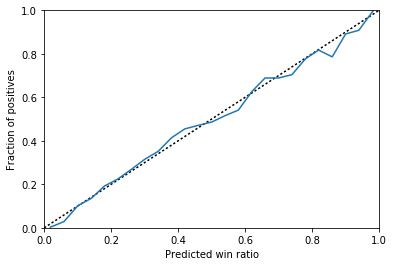

In [9]:
def plot_calibration_curve(model):
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.axis([0,1,0,1])
    plt.xlabel("Predicted win ratio")
    plt.ylabel("Fraction of positives")
    y_pred = model.predict(x_test)
    prob_pos = model.predict_proba(x_test)[:, 1]
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=25)
    plt.plot(mean_predicted_value, fraction_of_positives)
    
    plt.show()
    
plot_calibration_curve(logistic)

## Random forest

In [10]:
from sklearn.ensemble import RandomForestClassifier 

In [11]:
# Make model and fit to training set
forest = RandomForestClassifier(n_estimators=50)
forest.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [12]:
# Score the forest
forest.score(x_test,y_test)

0.88263648747773238

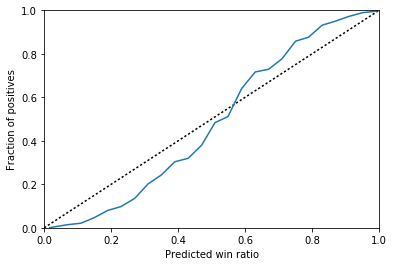

In [13]:
plot_calibration_curve(forest)

## Neural network

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler

In [15]:
# Set up pipeline for normalizing inputs
neural_net = make_pipeline(RobustScaler(),
                           MLPClassifier(
                               hidden_layer_sizes=(25,25,25),
                               verbose=True)
                          )

neural_net.fit(x_train, y_train)

Iteration 1, loss = 0.59359263
Iteration 2, loss = 0.51082682
Iteration 3, loss = 0.48874028
Iteration 4, loss = 0.48118027
Iteration 5, loss = 0.47671461
Iteration 6, loss = 0.47336740
Iteration 7, loss = 0.47106312
Iteration 8, loss = 0.46739402
Iteration 9, loss = 0.46436248
Iteration 10, loss = 0.46094264
Iteration 11, loss = 0.45921958
Iteration 12, loss = 0.45648062
Iteration 13, loss = 0.45451356
Iteration 14, loss = 0.45299361
Iteration 15, loss = 0.45158566
Iteration 16, loss = 0.44920675
Iteration 17, loss = 0.44942967
Iteration 18, loss = 0.44655271
Iteration 19, loss = 0.44549726
Iteration 20, loss = 0.44353474
Iteration 21, loss = 0.44298854
Iteration 22, loss = 0.44101352
Iteration 23, loss = 0.44005352
Iteration 24, loss = 0.43967278
Iteration 25, loss = 0.43832222
Iteration 26, loss = 0.43822191
Iteration 27, loss = 0.43711232
Iteration 28, loss = 0.43592732
Iteration 29, loss = 0.43475523
Iteration 30, loss = 0.43393891
Iteration 31, loss = 0.43304591
Iteration 32, los

Pipeline(steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('mlpclassifier', MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_...e=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=True, warm_start=False))])

In [16]:
neural_net.score(x_test,y_test)

0.76171015403961018

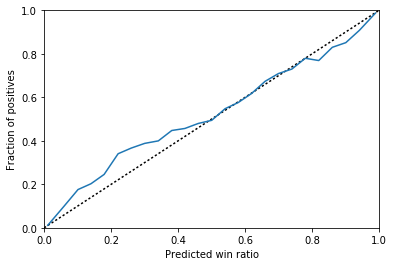

In [17]:
plot_calibration_curve(neural_net)

## SVM Classifier

In [19]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [26]:
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5]}
#              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
svm = GridSearchCV( SVC(kernel='rbf', class_weight='balanced'), param_grid )
#svm = SVC(kernel='rbf', C=1)
svm = svm.fit(x_train, y_train)
print("done in %0.3fs" % (time()-t0))

done in 122.964s


In [27]:
svm.score(x_test,y_test)

0.58032065388242693

In [28]:
plot_calibration_curve(svm)

AttributeError: predict_proba is not available when  probability=False